<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [38]:
#pip install statsmodels

In [80]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
import scipy.stats as stats
import pylab as plt
import seaborn as sns

In [3]:
# datos
datos = pd.read_csv('data/cookie_cats.csv')
datos.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Retention 1

In [49]:
pd.crosstab(datos.version, datos.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [10]:
datos.drop(columns=['userid'], axis=0).describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


In [50]:
pd.crosstab(datos.retention_1, datos.version)

version,gate_30,gate_40
retention_1,,
False,24666,25370
True,20034,20119


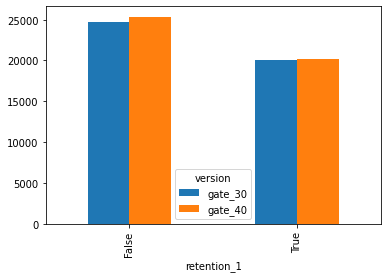

In [51]:
pd.crosstab(datos.retention_1, datos.version).plot(kind='bar');

➡️ Mismo cálculo para las dos retenciones

In [36]:
# comprobar si se repiten los usuarios
usuarios=datos.userid.value_counts(ascending=False)
#usuarios

In [58]:
# muestreo
control=datos[datos.version == 'gate_30'].sample(n=4720, random_state=42)

tratamiento=datos[datos.version == 'gate_40'].sample(n=4720, random_state=42)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False


In [60]:
#Misma muestra para cada grupo
ab_test.version.value_counts()

gate_30    4720
gate_40    4720
Name: version, dtype: int64

___________________________ ⬅️

In [78]:
retencion=ab_test.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))

retencion=retencion.agg([np.mean, std, error_std])
retencion.columns=['conv_rate', 'std', 'error_std']
retencion.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.443,0.497,0.007
gate_40,0.452,0.498,0.007


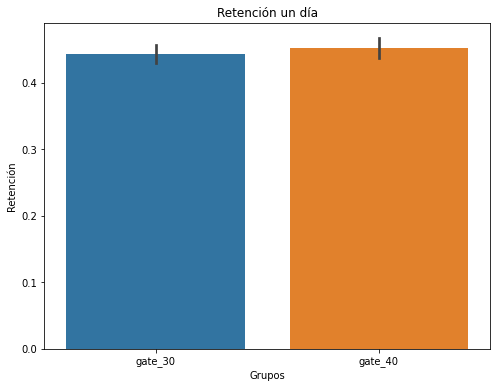

In [87]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'], 
            ci=95)


plt.title('Retención un día')
plt.xlabel('Grupos')
plt.ylabel('Retención');

In [ ]:
'''Gráficamente la diferencia entre el grupo de control (gate_30) y el grupo de tratamiento (gate_40) es prácticamente
imperceptible, lo que nos indicaría que los cambios en el juego no implicaría una mayor retención 
de los jugadores a un día''' 

In [88]:
control_res = ab_test[ab_test.version == 'gate_30']['retention_1']
tratamiento_res = ab_test[ab_test.version == 'gate_40']['retention_1']

In [89]:
n_con = control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat = tratamiento_res.count()

retenciones = [control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones = [n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(retenciones, nobs=observaciones)

z_score, p_value

(-0.8900490473879682, 0.373439550418591)

In [91]:
# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(retenciones, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

Control [0.42883724928125544, 0.4571796998712869]
Tratamiento [0.43792001018491333, 0.4663172779506799]


In [93]:
proportion_confint(retenciones, nobs=observaciones,alpha=0.05)[0][0]  # control_a

0.42883724928125544

In [ ]:
'''Dado que el pvalor=0.037 no es mayor que 0.05, 
podemos rechazar la hipótesis nula, lo que significa que cambiar la puerta del nivel 30 al 40, tiene 
una retención significativamente diferente a tenerla en el nivel 30 a un día.'''

## Retention 7

In [95]:
pd.crosstab(datos.version, datos.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [96]:
pd.crosstab(datos.retention_7, datos.version)

version,gate_30,gate_40
retention_7,,
False,36198,37210
True,8502,8279


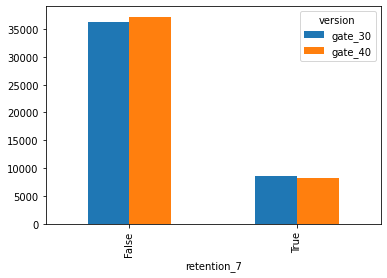

In [97]:
pd.crosstab(datos.retention_7, datos.version).plot(kind='bar');

In [98]:
retencion=ab_test.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))

retencion=retencion.agg([np.mean, std, error_std])
retencion.columns=['conv_rate', 'std', 'error_std']
retencion.style.format('{:.3f}')

,conv_rate,std,error_std
version,,,
gate_30,0.194,0.395,0.006
gate_40,0.183,0.387,0.006


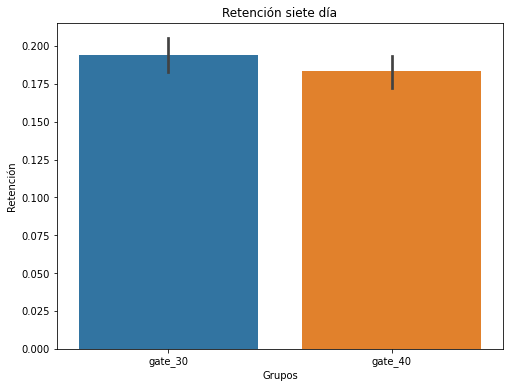

In [100]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'], 
            ci=95)


plt.title('Retención siete día')
plt.xlabel('Grupos')
plt.ylabel('Retención');

In [ ]:
'''Gráficamente la diferencia entre el grupo de control (gate_30) y el grupo de tratamiento (gate_40) muestra una
diferencia significativa, lo que nos indicaría que los cambios en el juego implicaría una disminución en la retención 
de los jugadores a siete días''' 

In [104]:
control_res = ab_test[ab_test.version == 'gate_30']['retention_7']
tratamiento_res = ab_test[ab_test.version == 'gate_40']['retention_7']

In [105]:
n_con = control_res.count()   # cuenta de elementos por grupo, ie, conversiones
n_trat = tratamiento_res.count()

retenciones = [control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones = [n_con, n_trat] # cuenta N de cada grupo

z_score, p_value = proportions_ztest(retenciones, nobs=observaciones)

z_score, p_value

(1.341646737016527, 0.1797105645649616)

In [106]:
# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(retenciones, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

Control [0.1827853552744774, 0.20535023794586157]
Tratamiento [0.17222560270103246, 0.19429982102778112]


In [107]:
proportion_confint(retenciones, nobs=observaciones,alpha=0.05)[0][0]  # control_a

0.1827853552744774

In [ ]:
'''Dado que el pvalor=0.17 es mayor que 0.05, 
no podemos rechazar la hipótesis nula, lo que significa que cambiar la puerta del nivel 30 al 40, tiene 
una baja retención de los jugadores a siete días.'''